Code to view the pulses kept alongside those cut away.

In [1]:
import sys
import time
import matplotlib.pyplot as plt # https://matplotlib.org/
import numpy as np # http://www.numpy.org/
import tekwfm
import os
from os.path import exists
from scipy import signal
from scipy import integrate
from scipy.optimize import curve_fit
from scipy.special import gamma
import matplotlib.cm as cm
from collections import Counter

import gc
import re
import tempfile
from collections import defaultdict, namedtuple
from pathlib import Path
import pandas as pd

1250
8e-11
samples 1250
Number of passing events in CSV: 8399
Bad events: [607, 608, 614, 616, 624, 625, 632, 639, 641, 644, 654, 659, 662, 663, 666, 668, 669, 674, 682, 685, 689, 691, 695, 696, 698, 699]
Good events: [600, 601, 602, 603, 604, 605, 606, 609, 610, 611, 612, 613, 615, 617, 618, 619, 620, 621, 622, 623, 626, 627, 628, 629, 630, 631, 633, 634, 635, 636, 637, 638, 640, 642, 643, 645, 646, 647, 648, 649, 650, 651, 652, 653, 655, 656, 657, 658, 660, 661, 664, 665, 667, 670, 671, 672, 673, 675, 676, 677, 678, 679, 680, 681, 683, 684, 686, 687, 688, 690, 692, 693, 694, 697]


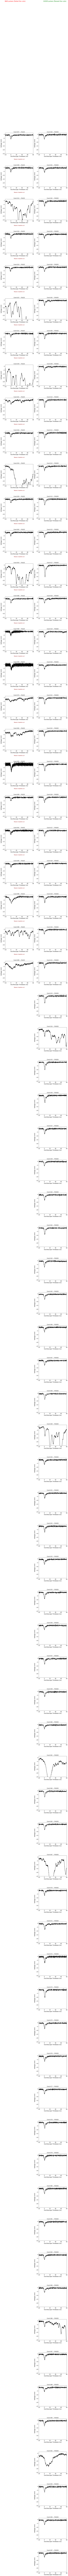

In [2]:
doVerbose = False

#import the wfm file
filename_wfm = "PMT4_WFM_DR/220126_darkrate_1800_10000_2_off"

#import the cleaned file and make data frame
clean_csv = pd.read_csv("PMT4_CLEAN_11SIG_DR/220126_darkrate_1800_10000_2_off_processed_threshold11_cleaned.csv")

#import the processed file
processed_csv = pd.read_csv("PMT4_11SIGMA_PROC_DR/CORRECTED_INDICES/220126_darkrate_1800_10000_2_off_processed_threshold11.csv")



#choose number of events to be seen and starting event (first event is event 0)
startEvent = 600
nEvents = 100



volts, tstart, tscale, tfrac, tdatefrac, tdate = tekwfm.read_wfm(filename_wfm+".wfm")
if doVerbose:
    print('>>>>', volts, tstart, tscale, tfrac, tdatefrac, tdate)

samples = volts.shape

print(len(volts))
print(tscale)
print('samples', samples[0])
tstop = samples[0]*tscale+tstart
sampleTimes = [tstart+x*tscale for x in range(samples[0])]





#the clean file is the list of all of the events which have passed the cuts, and should be good pulses
INDEX_COL_CLEAN = clean_csv["event_id"]
INDEX_COL_PROCESSED = processed_csv["event_id"]

passed_events = set(INDEX_COL_CLEAN.astype(int).values)
print(f"Number of passing events in CSV: {len(passed_events)}")


bad_events = []
good_events = []

#search the events in the wfm file for the good (appear in clean.csv) and bad (don't appear in clean.csv)
for event in range(startEvent, startEvent + nEvents):
    if event in passed_events:
        good_events.append(event)
    else:
        bad_events.append(event)

print("Bad events:", bad_events)
print("Good events:", good_events)



def get_rejection_reason(event):
    row = processed_csv[processed_csv["event_id"] == event]

    if row.empty:
        return "Event not found in processed.csv"

    row = row.iloc[0]

    if row["time_above_threshold"] <= 0:
        return "time_above_threshold <= 0"

    #if not time above threshold issue then must be because of baseline
    return "baseline cut"



n_bad = len(bad_events)
n_good = len(good_events)
n_rows = max(n_bad, n_good)

fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(12, 6*n_rows))

# Fix shape if only one row
if n_rows == 1:
    axes = np.array([axes])


#bad events
for i, event in enumerate(bad_events):

    tempVolt = volts[:, event]
    ax = axes[i, 0]

    ax.plot(np.array(sampleTimes)*1e9, np.array(tempVolt)*1e3, color='black')
    ax.tick_params(axis='both', labelsize=12)
    ax.set_xlabel('Oscilloscope Timebase (ns)', fontsize=14)
    ax.set_xlim(-20, 80)
    ax.set_ylabel('Voltage (mV)', fontsize=14)
    ax.set_ylim(-25, 2)

    reason = get_rejection_reason(event)

    ax.set_title(f"Event {event} — FAILED", fontsize=12)
    ax.text(
        0.5, -0.25,
        f"Reason: {reason}",
        transform=ax.transAxes,
        ha='center',
        va='top',
        fontsize=11,
        color='darkred',
        wrap=True
    )

    del tempVolt



#good events
for i, event in enumerate(good_events):

    tempVolt = volts[:, event]
    ax = axes[i, 1]

    ax.plot(np.array(sampleTimes)*1e9, np.array(tempVolt)*1e3, color='black')
    ax.tick_params(axis='both', labelsize=12)
    ax.set_xlabel('Oscilloscope Timebase (ns)', fontsize=14)
    ax.set_xlim(-20, 80)
    ax.set_ylabel('Voltage (mV)', fontsize=14)
    ax.set_ylim(-25, 2)

    ax.set_title(f"Event {event} — PASSED", fontsize=12)

    del tempVolt


for i in range(n_rows):
    if i >= n_bad:
        axes[i, 0].axis('off')
    if i >= n_good:
        axes[i, 1].axis('off')


fig.text(0.25, 0.985, "BAD pulses (Failed the cuts)", ha='center', va='top',
         fontsize=16, color='red')

fig.text(0.75, 0.985, "GOOD pulses (Passed the cuts)", ha='center', va='top',
         fontsize=16, color='green')

plt.subplots_adjust(top=0.94, hspace=0.6)
plt.show()